In [1]:
import time
import random
from math import *
import operator
import pandas as pd
import numpy as np
from collections import OrderedDict

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline 

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

# load make_blobs to simulate data
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification

# import the ML algorithm
from sklearn.ensemble import RandomForestClassifier

# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.datasets import make_classification

In [3]:
RANDOM_STATE = 123

#### make_classification

Parameters:	
- n_samples : int, optional (default=100) - The number of samples.

- n_features : int, optional (default=20) - The total number of features. 
>
- n_informative informative features, 
- n_redundant redundant features, 
- n_repeated duplicated features and 
- n_features-n_informative-n_redundant-n_repeated 

- n_informative : int, optional (default=2)
> The number of informative features. Each class is composed of a number of gaussian clusters each located around the vertices of a hypercube in a subspace of dimension n_informative. For each cluster, informative features are drawn independently from N(0, 1) and then randomly linearly combined within each cluster in order to add covariance. The clusters are then placed on the vertices of the hypercube.

- n_redundant : int, optional (default=2)
>The number of redundant features. These features are generated as random linear combinations of the informative features.

- n_repeated : int, optional (default=0)
> The number of duplicated features, drawn randomly from the informative and the redundant features.

- n_classes : int, optional (default=2) - The number of classes (or labels) 

- n_clusters_per_class : int, optional (default=2) - The number of clusters per class.

- shuffle : boolean, optional (default=True) - Shuffle the samples and the features.

- random_state : int, RandomState instance or None (default) - Determines random number generation for dataset crea

In [4]:
# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, 
                           n_features=25,
                           n_clusters_per_class=1, 
                           n_informative=15,
                           random_state=RANDOM_STATE)

In [5]:
np.unique(y)

array([0, 1])

In [18]:
# first 3 sample rows
X[:3]

array([[ 1.37615684,  0.02206421, -1.17824231, -1.09977743,  0.70109347,
         0.572063  ,  4.25958102, -2.09225305,  1.05197154, -0.22890023,
         4.3343013 ,  1.39031584, -0.83791412,  2.54916918, -0.37283279,
         1.01930111,  8.41131187,  3.55468848, -1.02368031,  2.5432978 ,
         0.06949643,  4.93007377, -0.56030357,  2.65435177, -0.31354115],
       [-0.89292982, -0.05534227,  1.52580719, -0.59321334,  2.26085041,
        -0.84873647, -0.30756135,  2.84476843, -1.20345663,  2.9694543 ,
         0.73996685, -3.02385907,  0.87613144, -0.7948774 ,  0.59843412,
         5.0766909 , -5.16352208, -1.20319047,  2.5770837 ,  0.09952076,
        -0.27314188, -2.83633984,  0.63211046, -0.63753717,  2.07115252],
       [ 0.21519044, -0.20876955, -1.50088828,  0.35348932, -0.80785457,
         1.43361961,  0.57466399, -2.06649831, -0.72825513, -2.95807745,
         1.16245807, -0.20862232, -0.75238212,  3.84984005,  0.46237685,
        -4.78580986,  3.90880675,  1.05351294,  1

In [19]:
y[:3]

array([1, 0, 1])

In [20]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

In [11]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
      RandomForestClassifier(  n_estimators=100,
                               warm_start=True, 
                               oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)
    ),
    ("RandomForestClassifier, max_features='log2'",
      RandomForestClassifier(  n_estimators=100,
                               warm_start=True, 
                               max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)
    ),
    ("RandomForestClassifier, max_features=None",
      RandomForestClassifier(  n_estimators=100,
                               warm_start=True, 
                               max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE)
    )
]

In [12]:
# just checking ...
for label, clf in ensemble_clfs:
    print(label, '\n', clf)

RandomForestClassifier, max_features='sqrt' 
 RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=123,
                       warm_start=True)
RandomForestClassifier, max_features='log2' 
 RandomForestClassifier(max_features='log2', oob_score=True, random_state=123,
                       warm_start=True)
RandomForestClassifier, max_features=None 
 RandomForestClassifier(max_features=None, oob_score=True, random_state=123,
                       warm_start=True)


In [13]:
# just checkin ...
OrderedDict((label, []) for label, _ in ensemble_clfs)

OrderedDict([("RandomForestClassifier, max_features='sqrt'", []),
             ("RandomForestClassifier, max_features='log2'", []),
             ('RandomForestClassifier, max_features=None', [])])

In [14]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
error_rate

OrderedDict([("RandomForestClassifier, max_features='sqrt'", []),
             ("RandomForestClassifier, max_features='log2'", []),
             ('RandomForestClassifier, max_features=None', [])])

In [15]:
# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

In [16]:
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

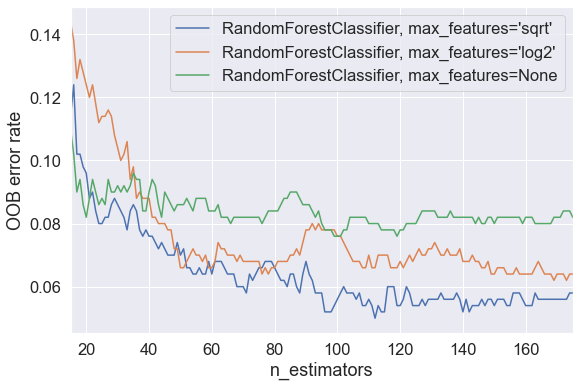

In [17]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(9,6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
1. Manual 
2. Grid/Random
3. p-values (col sig)
4. Feature engg (filter/wrapper)
5. RF ... (feature importances)
6. Bayesian methods